In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from geopy.distance import geodesic
import ast
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from numpy.linalg import inv
from scipy.stats import chi2
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
import scipy.stats as stats
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS, compare
import pymysql

In [241]:
raw_data = pd.read_excel("time.xlsx")
raw_data.head()

код зупинки А  код зупинки Б  час проїзду між А та Б  \
0            NaN          581.0                     NaN   
1          581.0          630.0                    60.0   
2          630.0          579.0                  1260.0   
3          579.0          671.0                   180.0   
4          671.0          676.0                    60.0   

  date time(день, місяць, рік, хвилина, секунда) на зупинці А  інтервал  
0                                                NaT                NaN  
1                                2025-02-18 09:48:00               16.0  
2                                2025-02-18 09:49:00               16.0  
3                                2025-02-18 10:10:00               17.0  
4                                2025-02-18 10:14:00               17.0

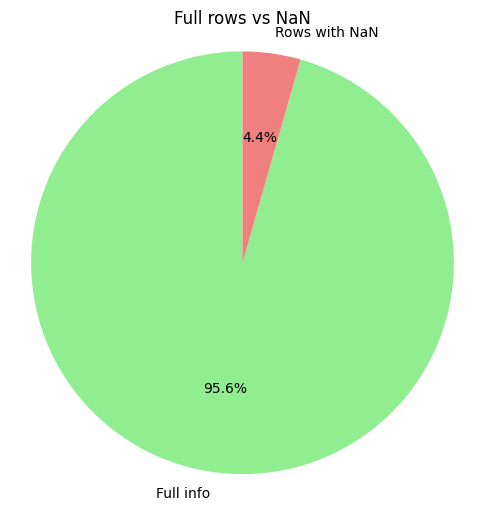

In [242]:
rows_with_na = raw_data.isna().any(axis=1).sum()

complete_rows = len(raw_data) - rows_with_na

labels = ['Full info', 'Rows with NaN']
sizes = [complete_rows, rows_with_na]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
plt.title('Full rows vs NaN')
plt.axis('equal')
plt.show()

In [243]:
raw_data = raw_data.dropna()

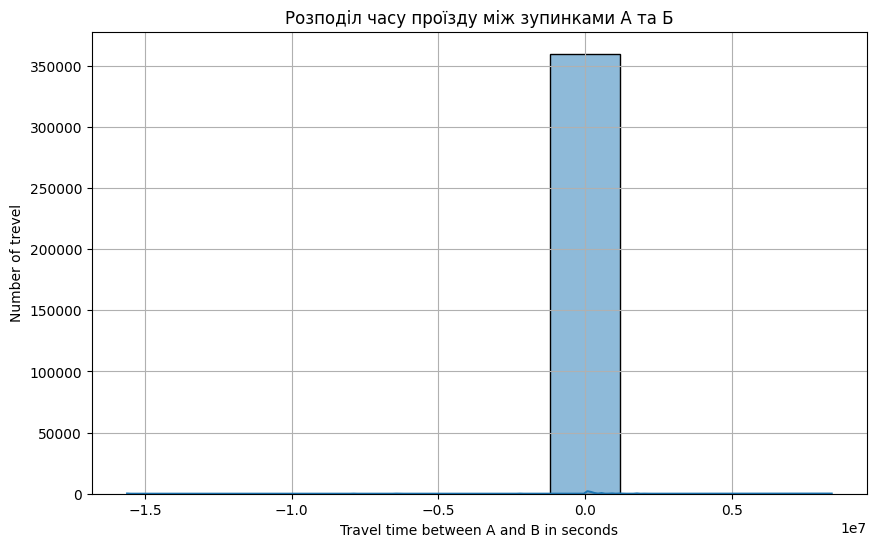

In [244]:
plt.figure(figsize=(10, 6))
sns.histplot(raw_data["час проїзду між А та Б"], bins=10, kde=True)
plt.xlabel("Travel time between А and B in seconds")
plt.ylabel("Number of trevel")
plt.title("Розподіл часу проїзду між зупинками А та Б")
plt.grid(True)
plt.show()

In [245]:
raw_data = raw_data[raw_data["час проїзду між А та Б"]>=0]

In [246]:
raw_data.rename(columns={"date time(день, місяць, рік, хвилина, секунда) на зупинці А": "datetime"}, inplace=True)
raw_data.drop(columns=["інтервал"], inplace=True)
raw_data["код зупинки А"]=raw_data["код зупинки А"].astype(int)
raw_data["код зупинки Б"]=raw_data["код зупинки Б"].astype(int)

In [247]:
raw_data["datetime"] = pd.to_datetime(raw_data["datetime"])
raw_data["date"] = raw_data["datetime"].dt.date

raw_data

код зупинки А  код зупинки Б  час проїзду між А та Б  \
1                 581            630                    60.0   
2                 630            579                  1260.0   
3                 579            671                   180.0   
4                 671            676                    60.0   
5                 676            675                  3720.0   
...               ...            ...                     ...   
376758             23            642                    60.0   
376759            642            579                    60.0   
376760            579            580                    60.0   
376761            580            671                    60.0   
376762            671            676                    60.0   

                  datetime        date  
1      2025-02-18 09:48:00  2025-02-18  
2      2025-02-18 09:49:00  2025-02-18  
3      2025-02-18 10:10:00  2025-02-18  
4      2025-02-18 10:14:00  2025-02-18  
5      2025-02-18 10:15:00  2025-02-18  
...                    ...         ...  
376758 2025-02-21 22:32:00  2025-02-21  
376759 2025-02-21 22:34:00  2025-02-21  
376760 2025-02-21 22:35:00  2025-02-21  
376761 2025-02-21 22:37:00  2025-02-21  
376762 2025-02-21 22:38:00  2025-02-21  

[359864 rows x 5 columns]

In [248]:
grouped_df = raw_data.groupby(["код зупинки А", "код зупинки Б", "datetime"])["час проїзду між А та Б"].mean().reset_index()

stops_data = pd.read_excel("довідник_зупинок.xlsx")

dct = {stop: ast.literal_eval(coords) for stop, coords in zip(stops_data["код зупинки"], stops_data["джпс координати"])}
def get_distance(A, B):
    return geodesic(dct[A], dct[B]).meters
grouped_df["distance"] = grouped_df.apply(lambda x: get_distance(x["код зупинки А"], x["код зупинки Б"]), axis=1)

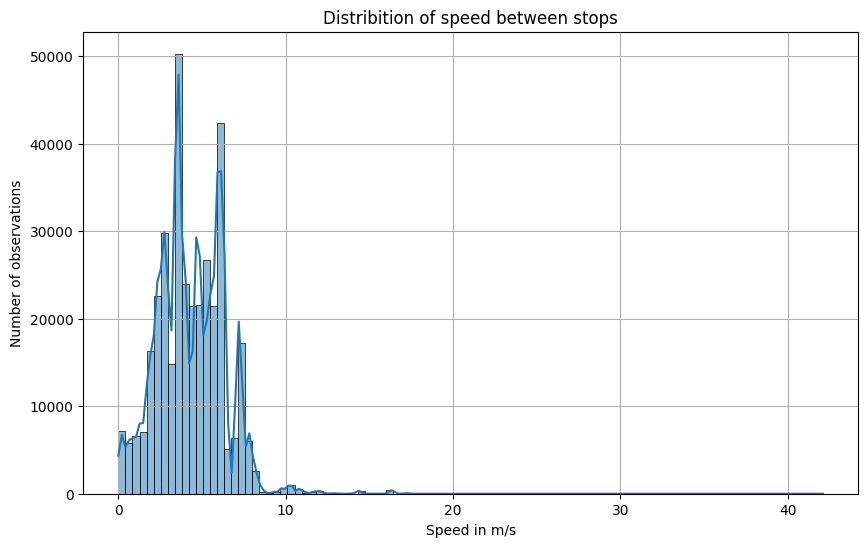

In [249]:
grouped_df["speed"] = grouped_df["distance"] / grouped_df["час проїзду між А та Б"]

plt.figure(figsize=(10, 6))
sns.histplot(grouped_df["speed"], bins=100, kde=True)
plt.xlabel("Speed in m/s")
plt.ylabel("Number of observations")
plt.title("Distribition of speed between stops")
plt.grid(True)
plt.show()

In [250]:
# grouped_df = grouped_df.drop(columns=['speed'])

grouped_df = grouped_df[grouped_df["distance"]/grouped_df["час проїзду між А та Б"]>0.277]
grouped_df = grouped_df[grouped_df["distance"]/grouped_df["час проїзду між А та Б"]<50/3.6]

In [251]:
# grouped_df
# grouped_df["datetime"] = pd.to_datetime(grouped_df["datetime"])
# grouped_df["hour"] = grouped_df["datetime"].dt.hour
# grouped_df["date"] = pd.to_datetime(grouped_df["datetime"]).dt.date
# time_bins = [6, 7, 10, 12, 14, 16, 17, 20, 22, 24]
# time_labels = ["6-7", "7-10", "10-12", "12-14", "14-16", "16-17", "17-20", "20-22", "22-24"]
# grouped_df["time_period"] = pd.cut(grouped_df["hour"], bins=time_bins, labels=time_labels, right=False)
# grouped = grouped_df.groupby(["time_period"], observed=True)["час проїзду між А та Б"].mean().reset_index()
# grouped

In [252]:
raw_data = grouped_df.copy().sort_values(by=["datetime"]).reset_index(drop=True)
raw_data["date"] = raw_data["datetime"].dt.date
raw_data.rename(columns={"код зупинки А": "stop_A", "код зупинки Б": "stop_B", "час проїзду між А та Б": "travel_time"}, inplace=True)
raw_data

stop_A  stop_B            datetime  travel_time     distance  \
0          674     584 2024-09-01 06:45:00        360.0  1027.945924   
1          584     630 2024-09-01 06:52:00         60.0   671.997018   
2          630     640 2024-09-01 06:54:00         60.0   138.001759   
3           16       2 2024-09-01 06:55:00        180.0  1039.715004   
4          640      45 2024-09-01 06:56:00         60.0   240.265352   
...        ...     ...                 ...          ...          ...   
352602     673     672 2025-02-28 23:24:00         60.0   277.145410   
352603     672     630 2025-02-28 23:25:00        120.0   840.358198   
352604     630     579 2025-02-28 23:27:00        660.0   191.687756   
352605     579     580 2025-02-28 23:38:00         60.0   352.516763   
352606     580     671 2025-02-28 23:39:00         60.0   370.339763   

            speed        date  
0        2.855405  2024-09-01  
1       11.199950  2024-09-01  
2        2.300029  2024-09-01  
3        5.776194  2024-09-01  
4        4.004423  2024-09-01  
...           ...         ...  
352602   4.619090  2025-02-28  
352603   7.002985  2025-02-28  
352604   0.290436  2025-02-28  
352605   5.875279  2025-02-28  
352606   6.172329  2025-02-28  

[352607 rows x 7 columns]

In [253]:
raw_data["hour"] = raw_data["datetime"].dt.hour
zxc = raw_data.groupby("hour")["travel_time"].mean().reset_index()
zxc = zxc[zxc["hour"]>=6]
mean_val = zxc["travel_time"].mean()
zxc["travel_time"] = zxc["travel_time"].apply(lambda x: x/mean_val)
zxc
# create dictionary for hour and mean travel time
weights = dict(zip(zxc["hour"], zxc["travel_time"]))
weights

{6: 1.233937784540907,
 7: 0.9719916210227216,
 8: 1.069109364974788,
 9: 1.052105251649733,
 10: 1.04640409114817,
 11: 0.9482439964086151,
 12: 0.9505116315527026,
 13: 0.9486101714481591,
 14: 0.986950537271328,
 15: 0.9864808673276447,
 16: 1.0087306848717281,
 17: 1.1165497070505177,
 18: 1.154959786087121,
 19: 0.9971727260135897,
 20: 0.915991249529886,
 21: 0.8861494724698615,
 22: 0.8829300598532406,
 23: 0.8431709967792863}

# Only suquential stops

In [254]:
route_name = "Т06"

def get_route_stadium(route_name):

    def get_connection():
        connection = pymysql.connect(
            host='transport.lviv.ua',
            user='transportlviv_ucu',
            password='busbooost',
            database='transportlviv_ucu',
            charset='utf8mb4'
        )
        return connection

    def export_from_db(table):
        connection = get_connection()
        query = f"SELECT * FROM {table}"
        df = pd.read_sql(query, connection)

        connection.close()

        return df

    dtype_spec = {5: str}
    stadium = export_from_db('stadium')
    try:
        new_route = route_name
    except:
        return None
    routeplan = stadium[stadium['route'] == new_route]['stop_id'].tolist()

    good_routeplan = []
    for i in range(0, len(routeplan)-1):
        if routeplan[i] != routeplan[i+1]:
            good_routeplan.append(routeplan[i])
    return good_routeplan
lst = get_route_stadium(route_name)
stop_intervals = [f"{a} - {b}" for a, b in zip(lst, lst[1:] + [lst[0]])]

In [255]:
raw_data['date'] = pd.to_datetime(raw_data['date']).dt.date 
try:
    raw_data['stop_interval'] = raw_data['stop_A'].astype(str) + ' - ' + raw_data['stop_B'].astype(str)
    raw_data.drop(columns=["stop_A", "stop_B"], inplace=True) 
except Exception:
    pass
raw_data = raw_data[raw_data["stop_interval"].isin(stop_intervals)]
print(raw_data["travel_time"].mean())


raw_data['weight'] = raw_data['hour'].map(weights)
raw_data['weighted_travel_time'] = raw_data['travel_time'] * raw_data['weight']
raw_data = raw_data.groupby(['date', 'stop_interval']).agg(
    weighted_avg_travel_time=('weighted_travel_time', lambda x: x.sum()),
    total_weight=('weight', 'sum'),
    distance=('distance', 'mean')  # Still take simple mean for distance
)

raw_data['travel_time'] = raw_data['weighted_avg_travel_time'] / raw_data['total_weight']
raw_data.drop(columns=['weighted_avg_travel_time', 'total_weight'], inplace=True)

raw_data.reset_index(inplace=True)
raw_data["travel_time"].mean()


109.07867363736682


99.70070428763658

In [256]:
raw_data

date stop_interval    distance  travel_time
0     2024-09-01     117 - 118  159.881812   117.080997
1     2024-09-01     118 - 188  292.247522    73.821816
2     2024-09-01      13 - 679  440.126460    82.311216
3     2024-09-01        14 - 2  641.652296   224.518024
4     2024-09-01       16 - 14  422.860900   101.683113
...          ...           ...         ...          ...
5595  2025-02-28     675 - 678  345.606586    63.703997
5596  2025-02-28     676 - 675  355.654507   105.390129
5597  2025-02-28     678 - 661  253.533655    60.000000
5598  2025-02-28      679 - 60  213.738646   107.600064
5599  2025-02-28      94 - 187  360.097843   137.638240

[5600 rows x 4 columns]

In [257]:
weather = pd.read_csv('your_weather_file.csv')
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather_selected = weather[['datetime', 'tempmax', 'tempmin', 'temp',
                             'dew', 'humidity', 'snow', 'precip',
                             'windspeed', 'cloudcover']]
raw_data['date'] = pd.to_datetime(raw_data['date'])

x = pd.merge_asof(raw_data.sort_values('date'), weather_selected.sort_values('datetime'), left_on='date', right_on='datetime', direction='backward')
def fahrenheit_to_celsius(f):
    return (f - 32) * 5/9
x["temp"] = x["temp"].apply(fahrenheit_to_celsius)
x["temp_range"] = x["tempmax"] - x["tempmin"]
x.drop(columns=['datetime', 'tempmax', 'tempmin'], inplace=True)
x

date stop_interval    distance  travel_time       temp   dew  \
0    2024-09-01     117 - 118  159.881812   117.080997  20.944444  60.3   
1    2024-09-01      94 - 187  360.097843   118.377160  20.944444  60.3   
2    2024-09-01      679 - 60  213.738646    65.181736  20.944444  60.3   
3    2024-09-01     678 - 661  253.533655   180.028560  20.944444  60.3   
4    2024-09-01     676 - 675  355.654507    64.557153  20.944444  60.3   
...         ...           ...         ...          ...        ...   ...   
5595 2025-02-28     118 - 188  292.247522    76.652022   2.555556  35.2   
5596 2025-02-28     117 - 118  159.881812    98.566212   2.555556  35.2   
5597 2025-02-28      679 - 60  213.738646   107.600064   2.555556  35.2   
5598 2025-02-28     580 - 671  370.339763    72.207358   2.555556  35.2   
5599 2025-02-28      94 - 187  360.097843   137.638240   2.555556  35.2   

      humidity  snow  precip  windspeed  cloudcover  temp_range  
0         74.3   0.0   0.000        5.1        68.1        23.8  
1         74.3   0.0   0.000        5.1        68.1        23.8  
2         74.3   0.0   0.000        5.1        68.1        23.8  
3         74.3   0.0   0.000        5.1        68.1        23.8  
4         74.3   0.0   0.000        5.1        68.1        23.8  
...        ...   ...     ...        ...         ...         ...  
5595      94.4   0.0   0.039       11.2        96.1         4.7  
5596      94.4   0.0   0.039       11.2        96.1         4.7  
5597      94.4   0.0   0.039       11.2        96.1         4.7  
5598      94.4   0.0   0.039       11.2        96.1         4.7  
5599      94.4   0.0   0.039       11.2        96.1         4.7  

[5600 rows x 12 columns]

In [258]:
# column with "weekday" or "weekend" valueus 
x["day_type"] = x["date"].apply(lambda x: "weekday" if x.weekday() < 5 else "weekend")
x = pd.get_dummies(x, columns=["day_type"], drop_first=True)
x

date stop_interval    distance  travel_time       temp   dew  \
0    2024-09-01     117 - 118  159.881812   117.080997  20.944444  60.3   
1    2024-09-01      94 - 187  360.097843   118.377160  20.944444  60.3   
2    2024-09-01      679 - 60  213.738646    65.181736  20.944444  60.3   
3    2024-09-01     678 - 661  253.533655   180.028560  20.944444  60.3   
4    2024-09-01     676 - 675  355.654507    64.557153  20.944444  60.3   
...         ...           ...         ...          ...        ...   ...   
5595 2025-02-28     118 - 188  292.247522    76.652022   2.555556  35.2   
5596 2025-02-28     117 - 118  159.881812    98.566212   2.555556  35.2   
5597 2025-02-28      679 - 60  213.738646   107.600064   2.555556  35.2   
5598 2025-02-28     580 - 671  370.339763    72.207358   2.555556  35.2   
5599 2025-02-28      94 - 187  360.097843   137.638240   2.555556  35.2   

      humidity  snow  precip  windspeed  cloudcover  temp_range  \
0         74.3   0.0   0.000        5.1        68.1        23.8   
1         74.3   0.0   0.000        5.1        68.1        23.8   
2         74.3   0.0   0.000        5.1        68.1        23.8   
3         74.3   0.0   0.000        5.1        68.1        23.8   
4         74.3   0.0   0.000        5.1        68.1        23.8   
...        ...   ...     ...        ...         ...         ...   
5595      94.4   0.0   0.039       11.2        96.1         4.7   
5596      94.4   0.0   0.039       11.2        96.1         4.7   
5597      94.4   0.0   0.039       11.2        96.1         4.7   
5598      94.4   0.0   0.039       11.2        96.1         4.7   
5599      94.4   0.0   0.039       11.2        96.1         4.7   

      day_type_weekend  
0                 True  
1                 True  
2                 True  
3                 True  
4                 True  
...                ...  
5595             False  
5596             False  
5597             False  
5598             False  
5599             False  

[5600 rows x 13 columns]

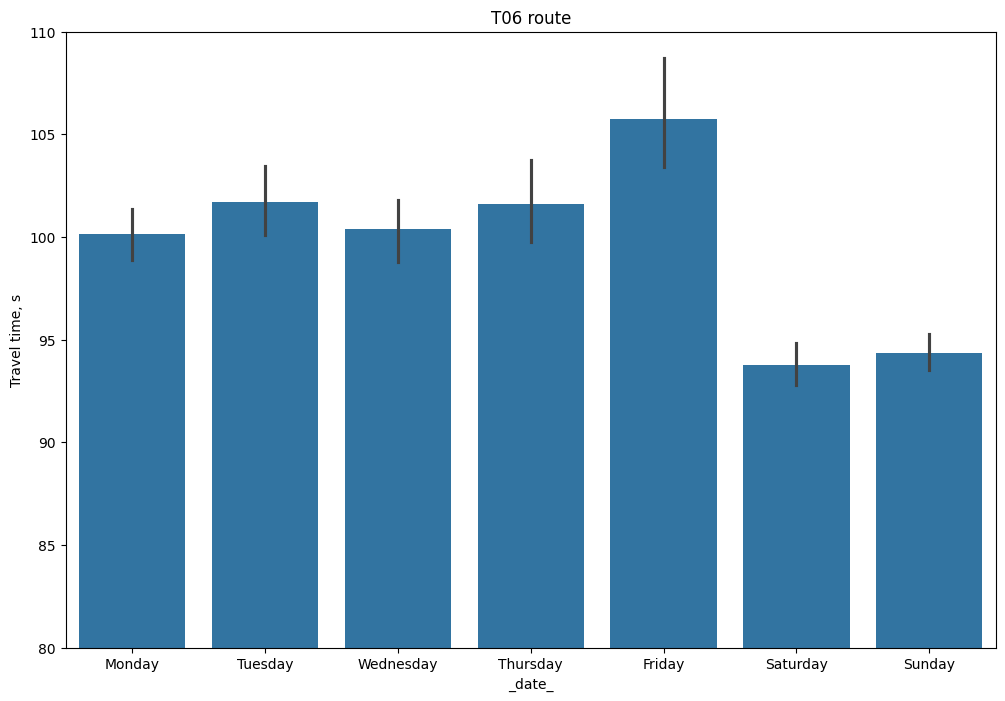

date  travel_time  _date_
43  2024-10-14   101.319619  Monday
36  2024-10-07    97.828519  Monday
169 2025-02-17   105.405199  Monday
50  2024-10-21    96.710466  Monday
29  2024-09-30   107.470411  Monday
..         ...          ...     ...
70  2024-11-10    92.161623  Sunday
133 2025-01-12    95.198008  Sunday
56  2024-10-27    92.254919  Sunday
91  2024-12-01    93.177039  Sunday
0   2024-09-01    92.059628  Sunday

[181 rows x 3 columns]

In [259]:
z = x.copy()
y = x.copy()
y.reset_index(inplace=True)
y = y.groupby(["date"])["travel_time"].mean().reset_index()
y["_date_"] = y["date"].dt.day_name()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y["_date_"] = pd.Categorical(y["_date_"], categories=days, ordered=True)
y.sort_values("_date_", inplace=True)
plt.figure(figsize=(12, 8))
ay = sns.barplot(x=y["_date_"], y=y["travel_time"], data=y)
ay.set_ylim(80, 110)
plt.title(f"T06 route")
plt.ylabel("Weekday")
plt.ylabel("Travel time, s")
plt.show()
y


In [260]:
x.set_index(["stop_interval","date"], inplace=True)
x["day_type_weekend"] = x["day_type_weekend"].astype(int)
x

distance  travel_time       temp   dew  humidity  \
stop_interval date                                                             
117 - 118     2024-09-01  159.881812   117.080997  20.944444  60.3      74.3   
94 - 187      2024-09-01  360.097843   118.377160  20.944444  60.3      74.3   
679 - 60      2024-09-01  213.738646    65.181736  20.944444  60.3      74.3   
678 - 661     2024-09-01  253.533655   180.028560  20.944444  60.3      74.3   
676 - 675     2024-09-01  355.654507    64.557153  20.944444  60.3      74.3   
...                              ...          ...        ...   ...       ...   
118 - 188     2025-02-28  292.247522    76.652022   2.555556  35.2      94.4   
117 - 118     2025-02-28  159.881812    98.566212   2.555556  35.2      94.4   
679 - 60      2025-02-28  213.738646   107.600064   2.555556  35.2      94.4   
580 - 671     2025-02-28  370.339763    72.207358   2.555556  35.2      94.4   
94 - 187      2025-02-28  360.097843   137.638240   2.555556  35.2      94.4   

                          snow  precip  windspeed  cloudcover  temp_range  \
stop_interval date                                                          
117 - 118     2024-09-01   0.0   0.000        5.1        68.1        23.8   
94 - 187      2024-09-01   0.0   0.000        5.1        68.1        23.8   
679 - 60      2024-09-01   0.0   0.000        5.1        68.1        23.8   
678 - 661     2024-09-01   0.0   0.000        5.1        68.1        23.8   
676 - 675     2024-09-01   0.0   0.000        5.1        68.1        23.8   
...                        ...     ...        ...         ...         ...   
118 - 188     2025-02-28   0.0   0.039       11.2        96.1         4.7   
117 - 118     2025-02-28   0.0   0.039       11.2        96.1         4.7   
679 - 60      2025-02-28   0.0   0.039       11.2        96.1         4.7   
580 - 671     2025-02-28   0.0   0.039       11.2        96.1         4.7   
94 - 187      2025-02-28   0.0   0.039       11.2        96.1         4.7   

                          day_type_weekend  
stop_interval date                          
117 - 118     2024-09-01                 1  
94 - 187      2024-09-01                 1  
679 - 60      2024-09-01                 1  
678 - 661     2024-09-01                 1  
676 - 675     2024-09-01                 1  
...                                    ...  
118 - 188     2025-02-28                 0  
117 - 118     2025-02-28                 0  
679 - 60      2025-02-28                 0  
580 - 671     2025-02-28                 0  
94 - 187      2025-02-28                 0  

[5600 rows x 11 columns]

# Assumptions

# linearity

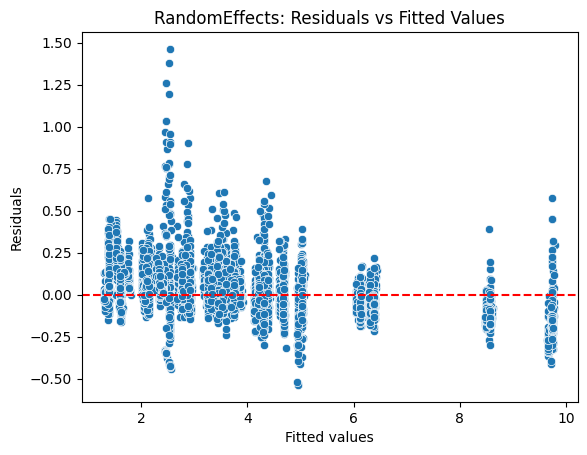

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                        RandomEffects Estimation Summary                        
================================================================================
Dep. Variable:            travel_time   R-squared:                        0.5078
Estimator:              RandomEffects   R-squared (Between):              0.8492
No. Observations:                5600   R-squared (Within):               0.0644
Date:                Fri, May 09 2025   R-squared (Overall):              0.8486
Time:                        17:46:27   Log-likelihood                    2889.5
Cov. Estimator:                Robust                                           
                                        F-statistic:                      961.78
Entities:                          31   P-value                           0.0000
Avg Obs:                       180.65   Distribution:                  F(6,5594)
Min Obs:                       170.00                                           
Max Obs:                       181.00   F-statistic (robust):             945.09
                                        P-value                           0.0000
Time periods:                     181   Distribution:                  F(6,5594)
Avg Obs:                       30.939                                           
Min Obs:                       30.000                                           
Max Obs:                       31.000                                           
                                                                                
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
distance             0.0099     0.0001     71.565     0.0000      0.0097      0.0102
temp                 0.0002     0.0003     0.5423     0.5876     -0.0004      0.0007
precip               0.0759     0.0177     4.2849     0.0000      0.0412      0.1106
snow                -0.0267     0.0090    -2.9573     0.0031     -0.0444     -0.0090
cloudcover           0.0002  7.314e-05     3.1609     0.0016    8.78e-05      0.0004
day_type_weekend    -0.0726     0.0047    -15.397     0.0000     -0.0818     -0.0634
====================================================================================
"""

In [261]:
y = np.log(x['travel_time'])
X = x[['distance', 'temp', 'precip', 'snow', 'cloudcover', 'day_type_weekend']].copy()
re_model = RandomEffects(y, X)
results = re_model.fit(cov_type='robust')



residuals = results.resids.squeeze()
fitted = results.fitted_values.squeeze()

sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("RandomEffects: Residuals vs Fitted Values")
plt.show()

results.summary


In [262]:
y = x['travel_time']
X = x[['distance', 'temp', 'precip', 'snow', 'windspeed', 'cloudcover', 'day_type_weekend']].copy()
ols_model = sm.OLS(y, X).fit()

reset_test = linear_reset(ols_model, power=2, use_f=True)

print(f"F-statistic: {reset_test.fvalue:.4f}")
print(f"P-value: {reset_test.pvalue:.4f}")


F-statistic: 3.8246
P-value: 0.0506


# Random Effects Assumption 

In [263]:
y = np.log(x['travel_time'])
X = x[['distance', 'temp', 'precip', 'snow', 'cloudcover', 'day_type_weekend']].copy()

fe_model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
fe_results = fe_model.fit(cov_type='robust')

b_fe = fe_results.params
b_re = results.params

common = b_fe.index.intersection(b_re.index)
b_diff = b_fe[common] - b_re[common]

v_fe = fe_results.cov.loc[common, common]
v_re = results.cov.loc[common, common]

stat = b_diff.T @ inv(v_fe - v_re) @ b_diff
df = len(common)
p_val = chi2.sf(stat, df)

print(f"Hausman test statistic: {stat:.4f}")
print(f"Degrees of freedom: {df}")
print(f"P-value: {p_val:.4f}")

Hausman test statistic: -8.4253
Degrees of freedom: 5
P-value: 1.0000


# Homoskedasticity

In [264]:
resid = results.resids.squeeze()

exog_panel = results.model.exog
exog = exog_panel.values2d

if not np.any(np.all(exog == 1, axis=0)):
    exog = sm.add_constant(exog)

# Тест Бреуша–Пагана
bp_test = het_breuschpagan(resid, exog)

labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))


{'Lagrange multiplier statistic': 10.15340786276857, 'p-value': 0.11833857297998104, 'f-value': 1.6931892864568159, 'f p-value': 0.11833290352566238}


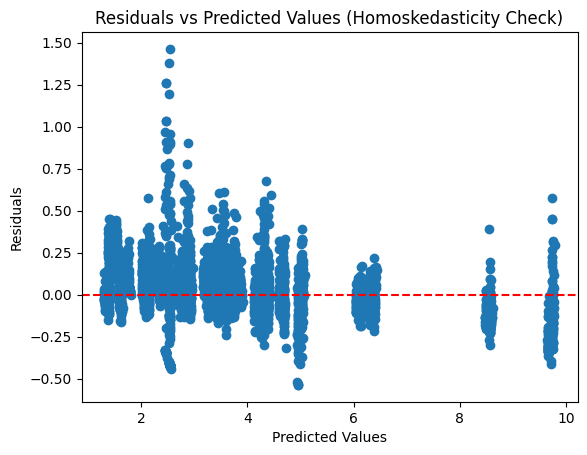

In [265]:
plt.scatter(fitted, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Homoskedasticity Check)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Serial Correlation

In [266]:
durbin_watson_test_results = durbin_watson(residuals)
print(durbin_watson_test_results)

1.8629515861780572


# No perfect collinearity

In [267]:
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


            feature       VIF
0          distance  3.468254
1              temp  1.564403
2            precip  1.497636
3              snow  1.286183
4        cloudcover  3.780761
5  day_type_weekend  1.355574


# Zero conditional mean

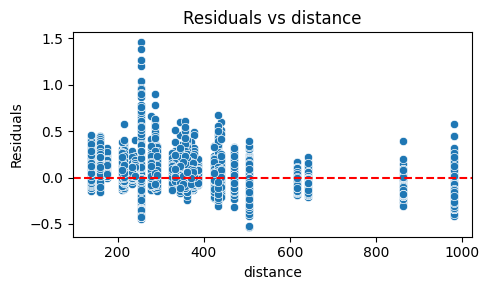

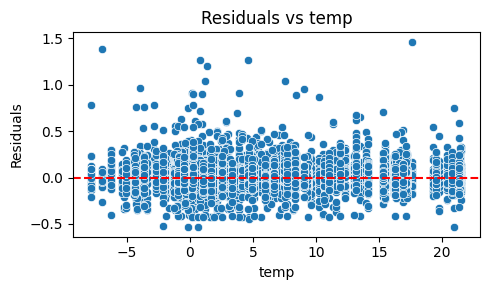

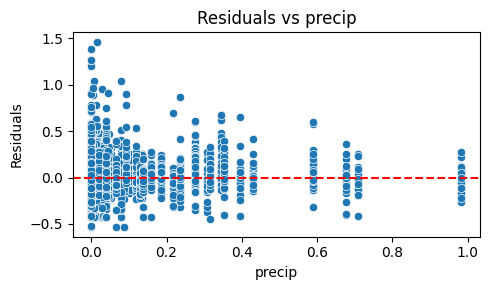

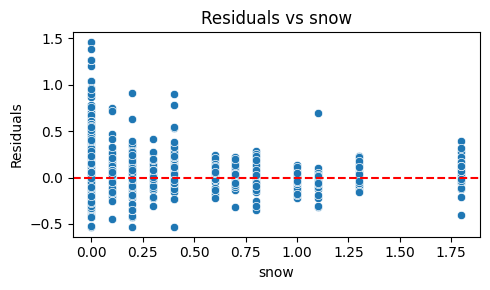

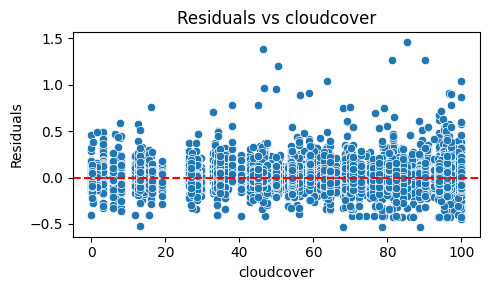

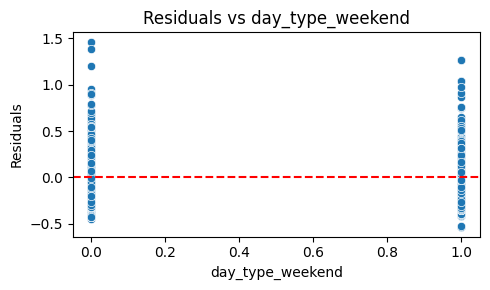

In [268]:
residuals = results.resids.squeeze()

for col in X.columns:
    plt.figure(figsize=(5, 3))
    sns.scatterplot(x=X[col], y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(col)
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs {col}")
    plt.tight_layout()
    plt.show()



# Normality of residuals

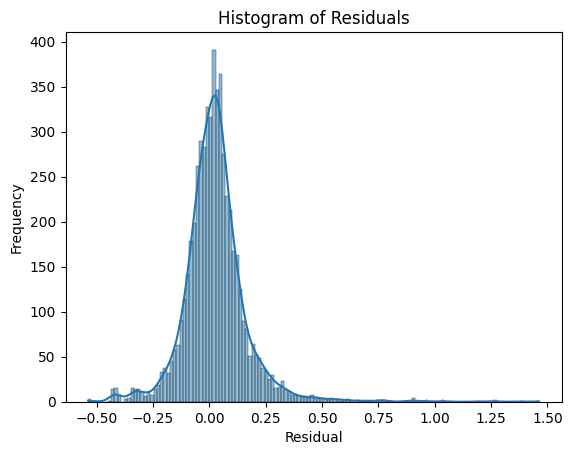

In [269]:
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


In [270]:
residuals = results.resids.squeeze()

# Shapiro–Wilk test
stat, p_value = shapiro(residuals)

print(f"Shapiro–Wilk test statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")


Shapiro–Wilk test statistic: 0.8853
P-value: 0.0000


# Strict exogeneity 

It guarantees that the model’s residuals (errors) do not depend on any values of the independent variables across all time periods.

In [271]:
resid = results.resids.squeeze()

dw_stat = durbin_watson(resid)
print(f"Durbin–Watson statistic: {dw_stat:.4f}")


Durbin–Watson statistic: 1.8630


In [272]:
x['lead_precip'] = x.groupby('stop_interval')['precip'].shift(-1)
X_test = x[['distance', 'temp', 'precip', 'lead_precip', 'snow', 'cloudcover', 'day_type_weekend']].dropna()
y_test = np.log(x.loc[X_test.index, 'travel_time'])

model_lead = RandomEffects(y_test, X_test)
results_lead = model_lead.fit()
results_lead.summary



<class 'linearmodels.compat.statsmodels.Summary'>
"""
                        RandomEffects Estimation Summary                        
================================================================================
Dep. Variable:            travel_time   R-squared:                        0.5011
Estimator:              RandomEffects   R-squared (Between):              0.8492
No. Observations:                5569   R-squared (Within):               0.0651
Date:                Fri, May 09 2025   R-squared (Overall):              0.8486
Time:                        17:46:29   Log-likelihood                    2900.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      797.99
Entities:                          31   P-value                           0.0000
Avg Obs:                       179.65   Distribution:                  F(7,5562)
Min Obs:                       169.00                                           
Max Obs:                       180.00   F-statistic (robust):             797.99
                                        P-value                           0.0000
Time periods:                     180   Distribution:                  F(7,5562)
Avg Obs:                       30.939                                           
Min Obs:                       30.000                                           
Max Obs:                       31.000                                           
                                                                                
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
distance             0.0099     0.0001     72.347     0.0000      0.0097      0.0102
temp                 0.0003     0.0003     0.8440     0.3987     -0.0003      0.0008
precip               0.0854     0.0174     4.9059     0.0000      0.0513      0.1195
lead_precip         -0.0279     0.0161    -1.7358     0.0827     -0.0594      0.0036
snow                -0.0270     0.0092    -2.9454     0.0032     -0.0449     -0.0090
cloudcover           0.0002  7.421e-05     3.2827     0.0010   9.813e-05      0.0004
day_type_weekend    -0.0727     0.0044    -16.610     0.0000     -0.0813     -0.0641
====================================================================================
"""

DW < 1.5 або > 2.5 then can be violated

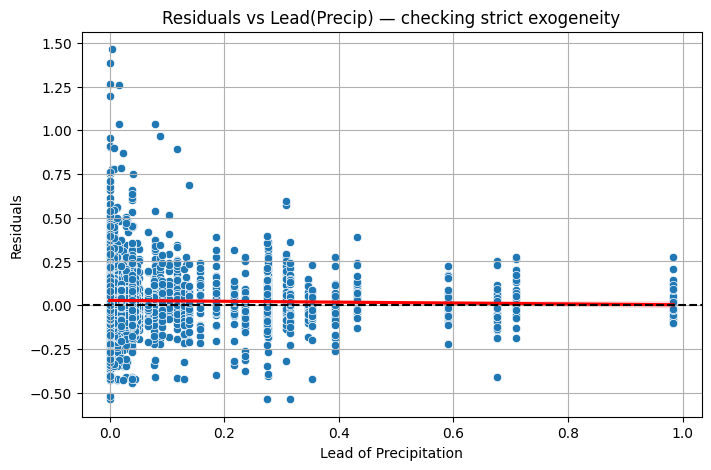

In [273]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=x["lead_precip"], y=results.resids)
sns.regplot(x=x["lead_precip"], y=results.resids, scatter=False, color='red')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel("Lead of Precipitation")
plt.ylabel("Residuals")
plt.title("Residuals vs Lead(Precip) — checking strict exogeneity")
plt.grid(True)
plt.show()


## Hausmann test

• H0: The appropriate model is Random effects. There is no correlation between the error term and the independent variables in the panel data model.

• H1: The appropriate model is Fixed effects. The correlation between the error term and the independent variables in the panel data model is statistically significant.

In [274]:
fe_model = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
fe_results = fe_model.fit()

re_model = RandomEffects(y, X)
re_results = re_model.fit()

def hausman(fe, re):
    b = fe.params
    B = re.params

    v_b = fe.cov
    v_B = re.cov

    common_coef = list(set(b.index).intersection(B.index))
    b = b[common_coef]
    B = B[common_coef]
    v_b = v_b.loc[common_coef, common_coef]
    v_B = v_B.loc[common_coef, common_coef]

    diff = b - B
    stat = np.dot(diff.T, np.linalg.inv(v_b - v_B)).dot(diff)
    df = len(diff)
    pval = stats.chi2.sf(stat, df)

    return stat, df, pval

stat, df, pval = hausman(fe_results, re_results)

print("Hausman test statistic:", round(stat, 4))
print("Degrees of freedom:", df)
print("P-value:", round(pval, 4))


Hausman test statistic: -9.4978
Degrees of freedom: 5
P-value: 1.0


In [275]:
pooled_model = PooledOLS(y, X).fit()

print(compare({'Pooled': pooled_model, 'Fixed Effects': fe_results}))

                    Model Comparison                   
                                 Pooled   Fixed Effects
-------------------------------------------------------
Dep. Variable               travel_time     travel_time
Estimator                     PooledOLS        PanelOLS
No. Observations                   5600            5600
Cov. Est.                    Unadjusted      Unadjusted
R-squared                        0.9352          0.0647
R-Squared (Within)              -39.681          0.0647
R-Squared (Between)              0.9717         -0.0038
R-Squared (Overall)              0.9352         -0.0038
F-statistic                   1.345e+04          76.980
P-value (F-stat)                 0.0000          0.0000
=====================     =============   =============
distance                         0.0049                
                               (72.477)                
temp                             0.0628      -1.603e-05
                               (28.425)       (-

In [276]:
results_compare = compare({'Pooled': pooled_model, 'Random Effects': results})
print(results_compare)

                  Model Comparison                 
                             Pooled  Random Effects
---------------------------------------------------
Dep. Variable           travel_time     travel_time
Estimator                 PooledOLS   RandomEffects
No. Observations               5600            5600
Cov. Est.                Unadjusted          Robust
R-squared                    0.9352          0.5078
R-Squared (Within)          -39.681          0.0644
R-Squared (Between)          0.9717          0.8492
R-Squared (Overall)          0.9352          0.8486
F-statistic               1.345e+04          961.78
P-value (F-stat)             0.0000          0.0000
===================== ============= ===============
distance                     0.0049          0.0099
                           (72.477)        (71.565)
temp                         0.0628          0.0002
                           (28.425)        (0.5423)
precip                      -2.2278          0.0759
            